0    1
1    0
2    1
3    0
4    1
Name: Score, dtype: int64

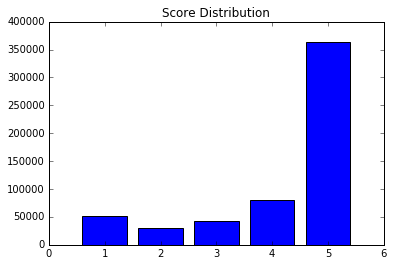

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import boto
import tflearn
import numpy as np
# import seaborn as sns
from tflearn.data_utils import to_categorical, pad_sequences, load_csv
from string import punctuation
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

# Defaults for pandas
pd.set_option('display.max_colwidth',1000)

# Load data from S3
original_review = pd.read_csv('s3a://amazon-fine-food-dataset/Reviews.csv')

# Analysis of data
s = pd.Series(original_review.Score)
s.describe()
s_counts = s.value_counts()
plt.bar(s_counts.index.tolist(), s_counts.values, align='center')
plt.title('Score Distribution')

# Data Preprocessing
temp = original_review.loc[:,["Text","Score"]]
temp = temp[temp.Score != 3]

def partition(x):
    if x < 3:
        return 0
    return 1

# Partition the data by 1-3 and 4-5 
Score = temp['Score']
Score = Score.map(partition)
Text = temp['Text']
Score.head()


# Removes punctuations in texts
# reviews = temp.Text.values
# labels = np.array(Score.values)
# reviews_cleaned = []

#for i in range(len(reviews)):
#    reviews_cleaned.append(''.join([c.lower() for c in reviews[i] if c not in punctuation]))

# new code start here









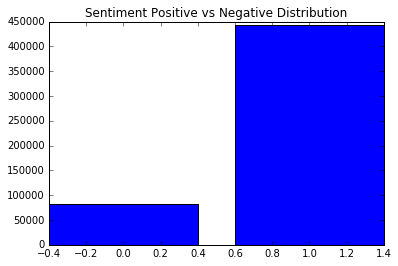

In [2]:

Score_counts = pd.Series(Score).value_counts()
plt.bar(Score_counts.index.tolist(), Score_counts.values, align='center')
plt.title('Sentiment Positive vs Negative Distribution')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(Text, Score, test_size=0.1, random_state=42)

from sklearn.feature_extraction.text import CountVectorizer
# Don't understand this token pattern
vect = CountVectorizer(ngram_range=(1,1), token_pattern=r'\b\w{1,}\b')
vect.fit(X_train)
vocab = vect.vocabulary_
def convert_X_to_X_word_ids(X):
    return X.apply(lambda x: [vocab[w] for w in [w.lower().strip() for w in x.split()] if w in vocab])

X_train_word_ids = convert_X_to_X_word_ids(X_train)
X_test_word_ids = convert_X_to_X_word_ids(X_test)

# See diff b/w X_train and X_train_words_ids
X_train.head()
X_train_word_ids.head()


157999                                                                                     [53666, 99111, 74469, 98805, 80325, 88301, 98776, 63223, 56559, 91775, 56559, 23069, 72856, 42737, 25277, 57800, 31915, 70332, 9522, 73241, 96705, 9522, 106609, 93997, 47220, 56559, 9927, 30794, 7924, 70480, 36703, 98805, 95339, 7924, 87161, 71909, 90562, 21341, 38167, 25277]
172079                                                                                                                                                                                                               [53666, 88100, 44700, 45813, 94978, 45015, 45813, 94978, 72412, 45813, 94978, 89489, 64757, 45813, 94978, 49716, 56559, 97728, 57800, 61120, 45813, 94978]
360782                                                                                                                                                                                                  [53666, 71986, 104100, 102062, 64528, 99293, 97960, 17520, 7924,

In [4]:
X_train_word_ids.shape
X_test_word_ids.shape

(52582,)

In [5]:
review_lengths = [len(review) for review in X_train_word_ids]
print("Shortest review:", min(review_lengths))
print("Longest revies:",max(review_lengths))

Shortest review: 0
Longest revies: 1843


In [6]:
pd.DataFrame(review_lengths).describe()

,0
count,473232.000000
mean,66.252094
std,64.730703
min,0.000000
25%,28.000000
50%,47.000000
75%,81.000000
max,1843.000000


In [7]:

max_length = 100
X_train_padded_seqs = pad_sequences(X_train_word_ids, maxlen=max_length, value=0)
X_test_padded_seqs = pad_sequences(X_test_word_ids, maxlen=max_length, value=0)

X_train_padded_seqs.shape


(473232, 100)

In [8]:
X_test_padded_seqs.shape

(52582, 100)

In [9]:
pd.DataFrame(X_train_padded_seqs).head()


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,53666,99111,74469,98805,80325,88301,98776,63223,56559,91775,...,0,0,0,0,0,0,0,0,0,0
1,53666,88100,44700,45813,94978,45015,45813,94978,72412,45813,...,0,0,0,0,0,0,0,0,0,0
2,53666,71986,104100,102062,64528,99293,97960,17520,7924,48501,...,0,0,0,0,0,0,0,0,0,0
3,67614,71450,98996,30361,9096,49038,92074,59668,4674,61557,...,0,0,0,0,0,0,0,0,0,0
4,70332,28936,98805,79076,71450,99160,71038,6266,72773,21517,...,0,0,0,0,0,0,0,0,0,0


In [10]:
pd.DataFrame(X_test_padded_seqs).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,99160,56422,4674,105093,51879,80934,36782,44596,107974,64829,...,9927,44700,22886,67946,25817,98738,72617,56559,100228,17440
1,53666,62234,99160,23367,66685,7924,98805,72773,2400,66695,...,0,0,0,0,0,0,0,0,0,0
2,4674,69675,95019,53666,7395,69517,99920,58457,7924,50920,...,0,0,0,0,0,0,0,0,0,0
3,53666,57800,45015,74835,7924,74835,107974,26672,7924,53666,...,0,0,0,0,0,0,0,0,0,0
4,34028,66317,97960,9522,71930,108528,70350,98776,38167,97960,...,0,0,0,0,0,0,0,0,0,0


In [11]:
unique_y_labels = list(y_train.value_counts().index)
unique_y_labels

[1, 0]

In [12]:

size_of_each_vector = X_train_padded_seqs.shape[1]
vocab_size = len(vocab)
no_of_unique_y_labels = len(unique_y_labels)
#from sklearn import preprocessing
#le = preprocessing.LabelEncoder()
#le.fit(unique_y_labels)
y_train= to_categorical(y_train, nb_classes=len(unique_y_labels))
y_test= to_categorical(y_test, nb_classes=len(unique_y_labels))

In [13]:
y_train.shape

(473232, 2)

In [14]:
y_test.shape

(52582, 2)

In [15]:
print("Size_of_each_vector: {0} \nvocab_size: {1} \nno_of_unique_y_labels: {2}".format(size_of_each_vector, vocab_size, no_of_unique_y_labels))

Size_of_each_vector: 100 
vocab_size: 110207 
no_of_unique_y_labels: 2


In [16]:
net = tflearn.input_data([None, max_length])
net = tflearn.embedding(net, input_dim=vocab_size, output_dim=128)
net = tflearn.lstm(net, 128, dropout=0.8)
net = tflearn.fully_connected(net, no_of_unique_y_labels, activation='softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy')
model = tflearn.DNN(net, tensorboard_verbose=0)



In [17]:
model.fit(X_train_padded_seqs, y_train, validation_set=(X_test_padded_seqs, y_test), n_epoch=5, show_metric=True, batch_size=100)

Training Step: 23664  | total loss: 0.06004 | time: 885.840s
| Adam | epoch: 005 | loss: 0.06004 - acc: 0.9848 -- iter: 473200/473232
Training Step: 23665  | total loss: 0.05922 | time: 919.842s
| Adam | epoch: 005 | loss: 0.05922 - acc: 0.9843 | val_loss: 0.15122 - val_acc: 0.9521 -- iter: 473232/473232
--


In [19]:
model.save('SavedModels/model1.tfl')
print('Model Saved!')

INFO:tensorflow:/home/ubuntu/pynb/SavedModels/model1.tfl is not in all_model_checkpoint_paths. Manually adding it.
Model Saved!


In [20]:
model.load('SavedModels/model1.tfl')
print('Model Loaded!')
from sklearn import metrics

INFO:tensorflow:Restoring parameters from /home/ubuntu/pynb/SavedModels/model1.tfl
Model Loaded!


In [21]:
pred_classes = [np.argmax(i) for i in model.predict(X_test_padded_seqs)]
true_classes = [np.argmax(i) for i in y_test]

print("\nRNN Classifier\'s Accuracy: {0}\n".format(metrics.accuracy_score(true_classes, pred_classes)))


RNN Classifier's Accuracy: 0.9520938724278271



In [26]:
from sklearn.metrics import f1_score
print("F1 score: {0}".format(f1_score(true_classes, pred_classes)))

F1 score: 0.9718052897261117


In [23]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(true_classes, pred_classes))

[[ 6651  1594]
 [  925 43412]]


In [27]:
from sklearn.metrics import recall_score, precision_score
print("precision score: {0} \nrecall score: {1}".format(precision_score(true_classes, pred_classes), recall_score(true_classes, pred_classes)))


precision score: 0.9645825001110963 
recall score: 0.9791370638518618


In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

vect = TfidfVectorizer(stop_words='english', 
                       token_pattern=r'\b\w{2,}\b',
                       min_df=1, max_df=0.1,
                       ngram_range=(1,2))
mnb = MultinomialNB(alpha=2)

mnb_pipeline = make_pipeline(vect, mnb)

In [32]:
mnb_pipeline.named_steps

{'multinomialnb': MultinomialNB(alpha=2, class_prior=None, fit_prior=True),
 'tfidfvectorizer': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=0.1, max_features=None, min_df=1,
         ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
         stop_words='english', strip_accents=None, sublinear_tf=False,
         token_pattern='\\b\\w{2,}\\b', tokenizer=None, use_idf=True,
         vocabulary=None)}

In [34]:
# Cross Validation
cv = cross_val_score(mnb_pipeline, Text, Score, scoring='accuracy', cv=10, n_jobs=-1)
print("\nMultinomialNB Classifier\'s Accuracy: {0}\n".format(cv.mean()))


MultinomialNB Classifier's Accuracy: 0.8454833828780519

